# Notes 

### October 19th 2020

**Progression :** 
* Remove IDs column Remove Twitter Ids, Remove punctuation, Convert uppercase into lowercase, Remove special characters, Delete URLs, Tokenization, Stemming, Generate token's frequencies, Stop words, First simple vectorization (bag of words), Create a "delete emojis" fonction, First modelisation with SVM, First Evaluation with f1 score, Add the specification of each function, Develop a modular programming, Develop an evaluation function (include an evolution graphic). 

**Further :**
* Explore others methods of vectorization - Implement the BERT method 
* Figure out the most import tokens in tweets 

# Libraries 

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import string 
import re 

from nltk.tokenize import TweetTokenizer
from nltk.probability import FreqDist
from nltk.stem import PorterStemmer 

import warnings
warnings.filterwarnings("ignore")

# Import the dataset

In [2]:
file = 'Data/data.csv'
dataframe = pd.read_csv(file, error_bad_lines=False, sep=";")

In [3]:
dataframe['Label'].value_counts()

none      11005
sexism     3110
racism     1932
none          2
Name: Label, dtype: int64

# Preprocessing

### Target encoding 

In [4]:
def encoding_target(y):
    '''
        y : Series 
    '''
    for i in range(y.shape[0]):
        if y[i] == 'sexism' or y[i] == 'racism':
            y[i] = 1
        else:
            y[i] = 0
    return y.astype('int')

### Data cleaning 

In [5]:
def data_cleaning(df):
    '''
        df : DataFrame 
    '''
    
    # Delete IDs
    df.drop('ID', axis=1, inplace=True)
    
    # First encoding 
    df['Label'].replace('none', 'not racist', inplace=True)
    df['Label'].replace('racism', 'racist', inplace=True)
    
    i = 0 
    for i in range(df['Tweets'].shape[0]):
        # Remove ids @ 
        df['Tweets'][i] = re.sub(r'@\S+', '', df['Tweets'][i])
        
        # Remove punctuation
        df['Tweets'][i] = "".join([char for char in df['Tweets'][i] if char not in string.punctuation])
        
        # Uppercase -> Lowercase 
        df['Tweets'][i] = df['Tweets'][i].lower()
        
        # Delete Url 
        df['Tweets'][i] = re.sub(r'http\S+', '', df['Tweets'][i])
        
        # Delete characters 
        df['Tweets'][i] = re.sub("ð|ÿ|‘|œ|¦|€|˜|™|¸|¤|‚|©|¡|…|”|“|‹|š|±|³|iâ|§|„|", '', df['Tweets'][i]) 
        
    return df

### Convert Emojis 

In [6]:
def convert_emojis(text): 
    '''
        text : string 
    '''
    import emoji
    text = emoji.demojize(text)
    text = text.replace('_','')
    return text.replace(':','')

### Tokenization

In [7]:
def tokenization(df):
    '''
        df : DataFrame 
    '''
    # Generate tokens
    tknz = TweetTokenizer()
    tokens = []
    
    i = 0
    for i in range(df['Label'].shape[0]):
        tokens.extend(tknz.tokenize(df['Tweets'][i]))
    
    return tokens

### Stemming 

In [8]:
def stemming(tokens):
    '''
        tokens : list 
    '''
    stemming = PorterStemmer()
    for token in tokens:
        token = stemming.stem(token)
    return tokens

### Tokens_Frequencies 

In [9]:
def tokens_frequencies(tokens):
    '''
        tokens : list 
    ''' 
    # Creation of a dataframe Tokens-Frequencies
    fdist = FreqDist()
    for token in tokens:
        fdist[token] += 1 
    tokens_freq = pd.DataFrame(list(fdist.items()), columns = ["Tokens","Frequencies"])
    
    # Sort the dataframe according to frequency of words
    tokens_freq.sort_values(by='Frequencies',ascending=False, inplace=True)
    
    return tokens_freq

### Stop Words 

In [10]:
# Is not used yet 
def stop_words(df):
    '''
        df : DataFrame
    '''
    from nltk.corpus import stopwords
    liste = []
    i = 0 
    for i in range(df.shape[0]):
        if df['Tokens'][i] not in stopwords.words('english'):
            liste.append([df['Tokens'][i],df['Frequencies'][i]])
    return pd.DataFrame(liste,columns=["Tokens","Frequencies"])

### Vectorization

In [11]:
def vectorization(df, nbr_tokens, nbr_tweets, token_frequency):
    '''
        df : DataFrame 
        nbr_tokens : int - the number of tokens from the token-frequency DataFrame 
        nbr_tweets : int - the number of tweets to vectorize 
        token_frequency : DataFrame - the array that contains the frequency of each token in nbr_tweets tweets 
    '''
    # Most frequent tokens
    most_freq = token_frequency['Tokens'][:nbr_tokens]

    # Vectorization 
    matrix = []
    for tweet in df['Tweets'][:nbr_tweets]:
        vector = []
        tknz = TweetTokenizer()
        tweet = tknz.tokenize(tweet)
        for token in most_freq:
            if token in tweet:
                vector.append(1)
            else:
                vector.append(0)
        matrix.append(vector)
    
    # Convert the matrix into a dataframe
    bag_of_words = pd.DataFrame(matrix, columns=most_freq)
    
    return bag_of_words

### Preprocessing 

In [12]:
def preprocessing(dataset, nbr_tokens, nbr_tweets):
    '''
        dataset : DataFrame - the raw data set 
        nbr_tokens : int - the number of tokens from the token-frequency DataFrame 
        nbr_tweets : int - the number of tweets to vectorize 
    '''
    # Copy the dataset
    df = dataset.copy()
    y = df['Label']
    
    # manipulations
    df_cleaned = data_cleaning(df)
    
    # tokenization
    tokens = tokenization(df_cleaned)
    
    # stemming
    tokens_stemmed = stemming(tokens)
    
    # tokens_frequencies 
    tokfreq = tokens_frequencies(tokens_stemmed)
    
    # Stop words 
    tokfreq = stop_words(tokfreq)
    
    # Generate a CSV file for Tokens-Frequencies
    tokfreq.to_csv("Word-Frenquency.csv")
    
    # vectorization
    X = vectorization(df, nbr_tokens, nbr_tweets, tokfreq)
    
    # Encoding target 
    y = encoding_target(y)
    
    # Split the data : Train set & Test set 
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, shuffle=True)
    
    return X_train, X_test, y_train, y_test

### Test preprocessing 

In [13]:
#X_train, X_test, y_train, y_test = preprocessing(dataframe, nbr_tokens=10, nbr_tweets=dataframe.shape[0])

In [14]:
#y_test.value_counts()

# Modeling 

In [15]:
#from sklearn.svm import SVC 
#model = SVC(kernel='linear')
#model.fit(X_train, y_train)
#y_pred = model.predict(X_test)

# Evaluation 

In [16]:
#from sklearn.metrics import f1_score
#print("F1 Score = ", f1_score(y_test, y_pred))

In [17]:
def evaluation(nbr_tokens):

    # import 
    file = 'Data/data.csv'
    dataframe = pd.read_csv(file, error_bad_lines=False, sep=";")
    
    # preprocessing 
    X_train, X_test, y_train, y_test = preprocessing(dataframe, nbr_tokens, nbr_tweets=dataframe.shape[0]) 


    # training 
    from sklearn.svm import SVC 
    model = SVC(kernel='linear')
    model.fit(X_train, y_train) 
    
    # prediction 
    y_pred = model.predict(X_test)

    # evaluation 
    from sklearn.metrics import f1_score, classification_report
    print(classification_report(y_test, y_pred))

    return f1_score(y_test, y_pred)


In [18]:
f1_scores = []
for i in [10, 50, 100, 200, 400, 500,1000, 1500, 2000]:
    f1_scores.append(evaluation(i))

              precision    recall  f1-score   support

           0       0.69      1.00      0.82      3336
           1       0.00      0.00      0.00      1479

    accuracy                           0.69      4815
   macro avg       0.35      0.50      0.41      4815
weighted avg       0.48      0.69      0.57      4815

              precision    recall  f1-score   support

           0       0.71      0.97      0.82      3336
           1       0.65      0.12      0.20      1479

    accuracy                           0.71      4815
   macro avg       0.68      0.54      0.51      4815
weighted avg       0.69      0.71      0.63      4815

              precision    recall  f1-score   support

           0       0.75      0.95      0.84      3336
           1       0.71      0.27      0.39      1479

    accuracy                           0.74      4815
   macro avg       0.73      0.61      0.61      4815
weighted avg       0.73      0.74      0.70      4815

              preci

(-0.25, 1.0)

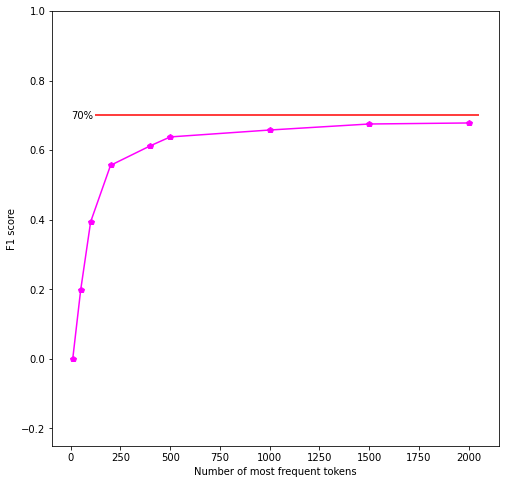

In [31]:
nbr_tokens = [10, 50, 100, 200, 400, 500,1000, 1500, 2000]
plt.figure(figsize=(8,8))
plt.plot(nbr_tokens, f1_scores, '-p', color='magenta')
plt.hlines(y = 0.7, xmin = 120, xmax = 2050, color ='r')
plt.text(1, 0.7, '70%', ha ='left', va ='center')
plt.xlabel('Number of most frequent tokens')
plt.ylabel('F1 score')
plt.ylim(-0.25,1)